In [8]:
import pandas as pd
import numpy as np
from datetime import timedelta
from itertools import product
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [9]:
df = pd.read_excel("../../data/raw/PSP_Jan_Feb_2019.xlsx", index_col=0)
psp = pd.DataFrame([["Moneycard",5,2],["Goldcard",10,5],["UK_Card",3,1],["Simplecard",1,0.5]],columns = ["psp","amount_success","amount_failed"])

## Datenqualität
### Duplikate entfernen und Spaltentypen konvertieren

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
df[["3D_secured","success"]] = df[["3D_secured","success"]].astype(bool)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50409
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tmsp        50329 non-null  datetime64[ns]
 1   country     50329 non-null  object        
 2   amount      50329 non-null  int64         
 3   success     50329 non-null  bool          
 4   PSP         50329 non-null  object        
 5   3D_secured  50329 non-null  bool          
 6   card        50329 non-null  object        
dtypes: bool(2), datetime64[ns](1), int64(1), object(3)
memory usage: 2.4+ MB


In [61]:
df[df.duplicated()]

,tmsp,country,amount,success,PSP,3D_secured,card,hour,week_day,Is_Outlier,amount_min_max,amount_std


In [5]:
# Wenn: dann std_scaler auf Grund der Regularisierung 
#min_max_scaler = MinMaxScaler()
#std_scaler = StandardScaler()
#df[["amount"]] = min_max_scaler.fit_transform(df[["amount"]])
#df[["amount"]] = std_scaler.fit_transform(df[["amount"]])

## Feature Engineering

### Mögliche Zusatzvariablen:
 - Anzahl vorheriger fehlgeschlagener Fehlversuche
 - Anzahl Versuche Gesamt

In [12]:
df_copy=df.sort_values(by=["country","amount","tmsp"]).reset_index().drop("index",axis=1)
condition = ((df_copy["amount"]==df_copy["amount"].shift(1))
               & (df_copy["country"]==df_copy["country"].shift(1))
               &  ((df_copy["tmsp"]-df_copy["tmsp"].shift(1))<timedelta(minutes=1)))
df_copy['i'] = np.where(condition,1,0)

In [13]:
def count_on_off(series):
    # Zähler initialisieren
    counter = 0
    # Liste für die kumulative Summe erstellen
    cum_sum = []
    # Durch die Elemente der Eingabeserie iterieren
    for value in series:
        if value == 1:
            # Wenn 1 auftritt, erhöhe den Zähler
            counter += 1
        else:
            # Wenn 0 auftritt, setze den Zähler zurück
            counter = 0
        # Füge den aktuellen Zählerwert zur kumulativen Summenliste hinzu
        cum_sum.append(counter)
    # Gib die kumulative Summenliste als Pandas-Serie zurück
    return pd.Series(cum_sum, index=series.index)

# Neue Spalte hinzufügen, die die kumulative Zählung von 0 und 1 enthält
df_copy["previous_attempts"] = count_on_off(df_copy["i"])

df_copy = df_copy[["tmsp", "country", "amount", "success", "PSP", "3D_secured", "card","previous_attempts"]]


In [7]:
df_copy.previous_attempts.value_counts()

previous_attempts
0    27613
1    12266
2     5606
3     2579
4     1201
5      577
6      277
7      138
8       71
9        1
Name: count, dtype: int64

### Zeitstempel
 - Wochentag
 - Tageszeit

In [14]:
df_copy["hour"] = df_copy.tmsp.dt.hour
df_copy["week_day"] = df_copy.tmsp.dt.weekday

#### One Hot Encoding

In [15]:
categorial_cols = ["PSP","country","card","hour","week_day"]
one_hot_encoded = pd.get_dummies(df_copy, columns=categorial_cols, drop_first=True)

In [16]:
one_hot_encoded.drop("tmsp", axis = 1, inplace=True)
one_hot_encoded.to_csv("../../data/preprocessed/PSP_Jan_Feb_2019_preprocessed.csv", sep=";", index=False)

## Feature Selection General

In [19]:
one_hot_copy

,amount,3D_secured,previous_attempts,PSP_Moneycard,PSP_Simplecard,PSP_UK_Card,country_Germany,country_Switzerland,card_Master,card_Visa,...,hour_20,hour_21,hour_22,hour_23,week_day_1,week_day_2,week_day_3,week_day_4,week_day_5,week_day_6
0,6,False,0,True,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,6,False,1,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,6,False,0,False,True,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
3,6,False,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,6,False,1,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50324,499,False,2,False,False,True,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
50325,499,False,3,False,False,True,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
50326,499,False,4,False,False,True,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False
50327,499,False,5,False,False,True,False,True,True,False,...,False,False,False,False,False,False,True,False,False,False


In [18]:
from sklearn.feature_selection import chi2
one_hot_copy = one_hot_encoded.copy()
target = one_hot_copy.pop("success")
chi2_stats, p_values = chi2(one_hot_copy, target)

In [20]:
p_values = pd.Series(p_values,index = one_hot_copy.columns)
p_values.sort_values(ascending = False , inplace = True)

hour_21           4.918946e-02
hour_12           4.342655e-02
hour_20           3.875237e-02
hour_13           1.877758e-02
hour_15           8.132152e-03
hour_14           5.545788e-03
hour_22           5.132655e-03
hour_18           1.491336e-03
PSP_UK_Card       7.369352e-04
week_day_1        5.087095e-04
PSP_Moneycard     4.110074e-04
hour_16           3.397225e-04
card_Master       1.487528e-04
hour_17           4.722319e-05
week_day_5        2.661018e-05
week_day_6        2.191658e-05
3D_secured        3.764129e-31
PSP_Simplecard    1.017109e-35
amount            0.000000e+00
dtype: float64


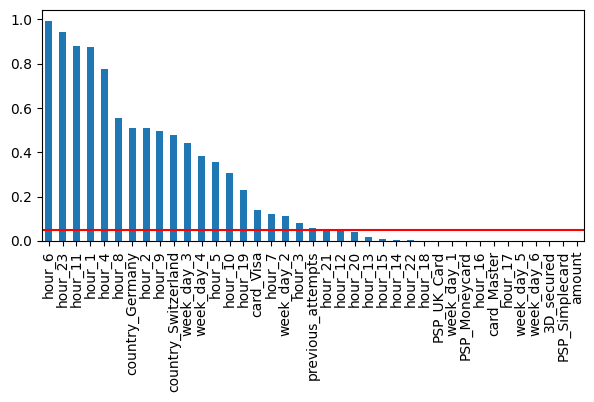

In [23]:
plt.figure(figsize=(7,3))
p_values.plot.bar();
plt.axhline(y=0.05, color='r', linestyle='-');
plt.savefig("../../documentation/data-reports/feature_selection.pdf", format="pdf", bbox_inches="tight")
print(p_values[p_values<0.05])

In [24]:
selected_features = list(p_values[p_values<0.05].index)
selected_features.append("success")
one_hot_encoded[selected_features].to_csv("../../data/preprocessed/PSP_Jan_Feb_2019_preprocessed_general_feature_selection.csv", sep=";", index=False)

### Outlier Detection

In [29]:
from pyod.models.ecod import ECOD

In [33]:
df

,tmsp,country,amount,success,PSP,3D_secured,card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners
...,...,...,...,...,...,...,...
50405,2019-02-28 23:45:39,Switzerland,415,0,UK_Card,0,Visa
50406,2019-02-28 23:46:48,Austria,91,0,UK_Card,0,Master
50407,2019-02-28 23:47:04,Austria,91,0,UK_Card,0,Master
50408,2019-02-28 23:47:36,Austria,91,0,UK_Card,0,Master


In [14]:
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.loci import LOCI

categorical_columns = ['tmsp', 'success']
continuous_column = 'amount'

# PyOD Isolation Forest Modell initialisieren
model = KNN()

# Trainieren des Modells auf den kontinuierlichen Spalten
model.fit(df[[continuous_column]])

# Vorhersage der Ausreißer
outlier_scores = model.decision_function(df[[continuous_column]])
outlier_labels = model.predict(df[[continuous_column]])

# Ausreißer markieren
df['Is_Outlier'] = outlier_labels

In [19]:
df[df["amount"]>435]

,tmsp,country,amount,success,PSP,3D_secured,card,hour,week_day,Is_Outlier
372,2019-01-01 07:26:03,Germany,450,False,Simplecard,False,Visa,7,1,1
506,2019-01-01 09:48:03,Germany,488,False,UK_Card,False,Master,9,1,1
507,2019-01-01 09:48:48,Germany,488,False,UK_Card,False,Master,9,1,1
508,2019-01-01 09:49:35,Germany,488,False,Simplecard,False,Master,9,1,1
509,2019-01-01 09:49:41,Germany,488,False,UK_Card,False,Master,9,1,1
...,...,...,...,...,...,...,...,...,...,...
49901,2019-02-28 08:38:53,Austria,442,False,UK_Card,False,Master,8,3,0
50235,2019-02-28 18:45:19,Switzerland,444,True,UK_Card,False,Master,18,3,0
50258,2019-02-28 19:24:55,Germany,463,False,UK_Card,True,Visa,19,3,1
50259,2019-02-28 19:24:59,Germany,463,True,Goldcard,True,Visa,19,3,1


In [ ]:
df[df["Is_Outlier"]==1]

In [17]:
df[df["Is_Outlier"]==1].head(50)

,tmsp,country,amount,success,PSP,3D_secured,card,hour,week_day,Is_Outlier
372,2019-01-01 07:26:03,Germany,450,False,Simplecard,False,Visa,7,1,1
506,2019-01-01 09:48:03,Germany,488,False,UK_Card,False,Master,9,1,1
507,2019-01-01 09:48:48,Germany,488,False,UK_Card,False,Master,9,1,1
508,2019-01-01 09:49:35,Germany,488,False,Simplecard,False,Master,9,1,1
509,2019-01-01 09:49:41,Germany,488,False,UK_Card,False,Master,9,1,1
3226,2019-01-03 17:37:22,Germany,487,True,Moneycard,False,Master,17,3,1
3317,2019-01-03 19:09:04,Germany,534,False,Simplecard,False,Master,19,3,1
5486,2019-01-06 01:45:19,Austria,520,False,Moneycard,False,Visa,1,6,1
5489,2019-01-06 01:50:18,Austria,516,True,UK_Card,True,Master,1,6,1
5546,2019-01-06 03:48:44,Germany,496,False,UK_Card,False,Master,3,6,1


## ere